In [2]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from scipy.sparse import csr_matrix
import implicit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

C:\Users\alfem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# Load the ratings dataset
ratings_df = pd.read_csv('ratings.csv', 
                         sep='::', 
                         names=['UserID', 'MovieID', 'Rating', 'Timestamp'], 
                         engine='python')




FileNotFoundError: [Errno 2] No such file or directory: 'ratings.csv'

In [22]:
# Ensure both MovieID columns are the same data type (e.g., integer)
ratings_df['MovieID'] = ratings_df['MovieID'].astype(int)
movies_df['MovieID'] = movies_df['MovieID'].astype(int)

# Identify the MovieIDs that are in ratings_df but not in movies_df
missing_movie_ids = ratings_df[~ratings_df['MovieID'].isin(movies_df['MovieID'])]

# Check how many rows will be removed
print(f"Number of rows to be removed: {missing_movie_ids.shape[0]}")

# Remove rows from ratings_df where MovieID is missing in movies_df
ratings_df_cleaned = ratings_df[ratings_df['MovieID'].isin(movies_df['MovieID'])]

# Optionally, reset the index if needed
ratings_df_cleaned.reset_index(drop=True, inplace=True)

# Print the cleaned dataframe
print(ratings_df_cleaned.head())


Number of rows to be removed: 0
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291



Understanding data

In [3]:
# Count the number of users whose age is less than 18
under_18_count = (users_df["Age"] < 18).sum()
print(f"Number of users under 18: {under_18_count}")

# Check for missing values in each column
missing_data = users_df.isnull().sum()
print(missing_data)
# Check for missing values in each column
missing_data = movies_df.isnull().sum()
print(missing_data)
# Check for missing values in each column
missing_data = ratings_df.isnull().sum()
print(missing_data)



Number of users under 18: 222
UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64
MovieID    0
Title      0
Genres     0
dtype: int64
UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64


In [23]:
# Define a function to categorize ages with custom labels
def categorize_age_with_labels(age):
    if age < 18:
        return 'teenager'
    elif 18 <= age <= 24:
        return 'teenager'
    elif 25 <= age <= 34:
        return 'earlyadult'
    elif 35 <= age <= 44:
        return 'midadult'
    elif 45 <= age <= 49:
        return 'lateadult'
    elif 50 <= age <= 55:
        return 'lateadult'
    else:
        return 'senior'

# Apply the function to the 'Age' column to categorize ages with custom labels
users_df['Age_Category'] = users_df['Age'].apply(categorize_age_with_labels)
users_df

,UserID,Gender,Age,Occupation,Zip-code,Age_Category
0,1,F,1,10,48067,teenager
1,2,M,56,16,70072,senior
2,3,M,25,15,55117,earlyadult
3,4,M,45,7,02460,lateadult
4,5,M,25,20,55455,earlyadult
...,...,...,...,...,...,...
6035,6036,F,25,15,32603,earlyadult
6036,6037,F,45,1,76006,lateadult
6037,6038,F,56,1,14706,senior
6038,6039,F,45,0,01060,lateadult


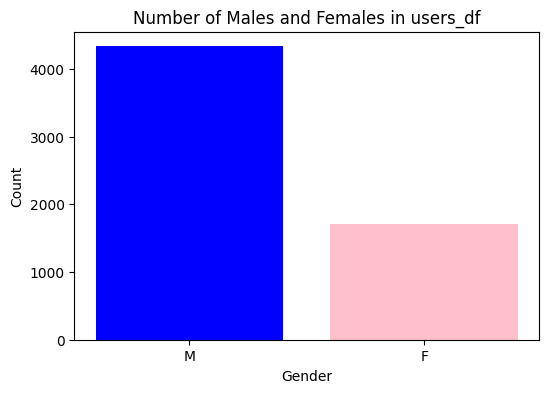

In [26]:
gender_counts = users_df["Gender"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(gender_counts.index, gender_counts.values, color=["blue", "pink"])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Number of Males and Females in users_df')
plt.show()

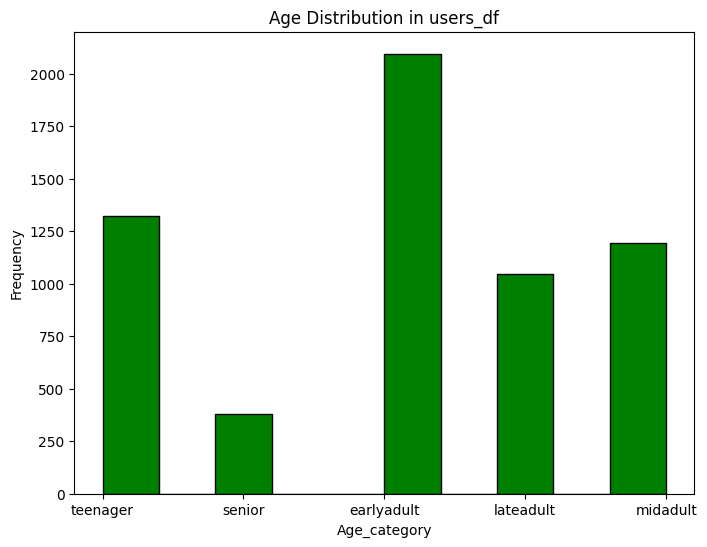

In [27]:
# Create a histogram to visualize the distribution of ages
plt.figure(figsize=(8, 6))
plt.hist(users_df["Age_Category"], bins=10, color='green', edgecolor='black')
plt.xlabel('Age_category')
plt.ylabel('Frequency')
plt.title('Age Distribution in users_df')
plt.show()

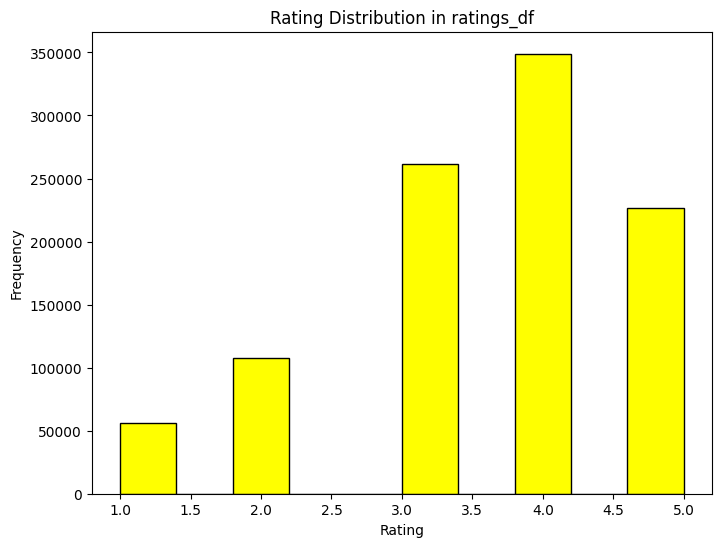

In [28]:
# Create a histogram to visualize the distribution of ratings
plt.figure(figsize=(8, 6))
plt.hist(ratings_df["Rating"], bins=10, color='yellow', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution in ratings_df')
plt.show()

(3883, 3)

Data preprocessing

In [24]:
# Remove any user with younger than 14
users_df = users_df[users_df["Age"] > 14]
print(users_df.shape)


(5818, 6)


In [35]:
# Combine users_df with ratings_df on 'UserID'
user_ratings_df = pd.merge(users_df, ratings_df, on='UserID')

# Combine the resulting dataframe with movies_df on 'MovieID'
recommendation_df = pd.merge(user_ratings_df, movies_df, on='MovieID')

# Remove the 'Timestamp', 'Zip-code', 'MovieID', and 'UserID' columns
recommendation_df = recommendation_df.drop(columns=['Timestamp', 'Zip-code', 'Age'])
# Create a dictionary that maps occupation codes to their corresponding descriptions
occupation_mapping = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

# Apply the mapping to the 'Occupation' column in the recommendation_df
recommendation_df['Occupation'] = recommendation_df['Occupation'].map(occupation_mapping)

# Check the first few rows to verify the change
print(recommendation_df.head())




   UserID Gender         Occupation Age_Category  MovieID  Rating  \
0       2      M      self-employed       senior     1357       5   
1       8      M         programmer   earlyadult     1357       4   
2      10      F  academic/educator     midadult     1357       5   
3      18      F     clerical/admin     teenager     1357       5   
4      33      M     clerical/admin    lateadult     1357       4   

          Title         Genres  
0  Shine (1996)  Drama|Romance  
1  Shine (1996)  Drama|Romance  
2  Shine (1996)  Drama|Romance  
3  Shine (1996)  Drama|Romance  
4  Shine (1996)  Drama|Romance  


In [36]:
duplicates = movies_df[movies_df.duplicated(subset='MovieID', keep=False)]
print(duplicates)
missing_titles = movies_df[movies_df['Title'].isna()]
print(missing_titles)


Empty DataFrame
Columns: [MovieID, Title, Genres]
Index: []
Empty DataFrame
Columns: [MovieID, Title, Genres]
Index: []


1. Collaborative Filtering

In [37]:

user_movie_matrix = recommendation_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)

# Convert the interaction matrix to a sparse matrix (CSR format)
sparse_user_movie_matrix = csr_matrix(user_movie_matrix.values)

# Train-test split
train_data, test_data = train_test_split(recommendation_df, test_size=0.2, random_state=42)

# Create the training user-item matrix
train_user_movie_matrix = train_data.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
sparse_train_user_movie_matrix = csr_matrix(train_user_movie_matrix.values)

# Initialize the ALS model
als_model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20)

# Fit the model on the training data
als_model.fit(sparse_train_user_movie_matrix.T)  # Note the transpose .T

# Get the latent factors after training
user_factors = als_model.user_factors
item_factors = als_model.item_factors

# Define a function to predict the rating for a specific user and movie
def predict_rating(user_id, movie_id):
    # Ensure that the user and movie IDs are within bounds
    if user_id < len(user_factors) and movie_id < len(item_factors):
        return np.dot(user_factors[user_id], item_factors[movie_id])
    else:
        return np.nan  # Return NaN if the user or movie isn't in the matrix

# Predict the ratings for the test set
predicted_ratings = []
actual_ratings = []

for i in range(len(test_data)):
    user_id = test_data.iloc[i]['UserID'] - 1  # Subtract 1 if IDs are 1-indexed in your data
    movie_id = test_data.iloc[i]['MovieID'] - 1  # Subtract 1 if IDs are 1-indexed
    actual_rating = test_data.iloc[i]['Rating']
    
    predicted_rating = predict_rating(user_id, movie_id)
    
    if not np.isnan(predicted_rating):  # Only consider valid predictions
        predicted_ratings.append(predicted_rating)
        actual_ratings.append(actual_rating)

# Compute the RMSE
mse = mean_squared_error(actual_ratings, predicted_ratings)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")



C:\Users\alfem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.006533622741699219 seconds
  warnings.warn(
100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


RMSE: 3.6851576958039645


In [8]:
user_movie_matrix = recommendation_df.pivot(index='UserID', columns='MovieID',  values='Rating')

user_movie_matrix = user_movie_matrix.fillna(0)

sparse_user_movie_matrix = csr_matrix(user_movie_matrix.values)



In [82]:
print(user_movie_matrix.shape)

print(sparse_user_movie_matrix.shape)

(5818, 3702)
(5818, 3702)


In [9]:
np.random.seed(42)

# ALS model initialization with fixed parameters
als_model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, random_state=42)

# Fit the model
als_model.fit(sparse_user_movie_matrix.T)


user_factors = als_model.user_factors
item_factors = als_model.item_factors



C:\Users\alfem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
C:\Users\alfem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.01228785514831543 seconds
  warnings.warn(
100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


In [10]:
print(user_factors.shape)
print(item_factors.shape)

(3702, 50)
(5818, 50)


In [11]:
print(user_factors[0])
print(item_factors[0])
predicted_rating = np.dot(user_factors[0], item_factors[0])
print(predicted_rating)

[ 0.7366421   2.4496806   2.992107    0.5214765   3.1219742   2.2870393
  3.0463676   0.4514714   1.1442128   1.8244832   5.4125514   3.0176077
  0.10885317  4.7432666   3.2208319   2.4286032   4.600391    0.84551454
  1.6936253   0.8246323   5.756264    3.372149    1.9997407   1.4717408
  1.7049394   1.914825    2.1527977   3.1264765   3.6847174   1.9998668
  1.8425488   3.630234    2.2241304   3.1709545   2.0043619  -0.74195427
  0.9093261   1.5273421  -0.0596091   3.5396278   2.1841998   2.3883479
  2.1599455   2.1214101   0.9651468   2.6863143   1.4099361   4.4705453
  3.4412506   1.9032372 ]
[-0.03151038  0.04371999  0.00827599  0.01317375  0.01630399  0.01486648
 -0.00124265  0.01858744 -0.00497697  0.00172473  0.01930789 -0.04839942
 -0.00600327  0.04352735  0.02570378  0.07509602 -0.00644922  0.01172651
  0.00776086  0.0027693  -0.02774781 -0.01624118  0.02526522 -0.01825968
 -0.00077252  0.00583231 -0.0183057   0.04493768  0.04339387 -0.01505444
 -0.00962784 -0.00150219  0.037

In [12]:
# Specify the user ID for recommendations
user_id = 2  # A valid user_id in your dataset

# Get the user's interaction row (as a sparse matrix row)
user_interactions = sparse_user_movie_matrix.getrow(user_id)

# Make recommendations by passing the user's interaction matrix
recommendations = als_model.recommend(user_id, user_interactions, N=5)
# Extract the arrays from the recommendations tuple
movie_ids, scores = recommendations

# Iterate over both arrays
for movie_id, score in zip(movie_ids, scores):
    print(f"MovieID: {movie_id}, Score: {score}")
# Assuming 'recommendation_df' contains 'MovieID' and 'Title' columns
for movie_id, score in zip(movie_ids, scores):
    # Check if the MovieID exists in recommendation_df
    if not recommendation_df[recommendation_df['MovieID'] == movie_id].empty:
        movie_title = recommendation_df[recommendation_df['MovieID'] == movie_id]['Title'].values[0]
        print(f"Movie: {movie_title}, MovieID: {movie_id}, Score: {score}")
    else:
        print(f"MovieID: {movie_id} not found in recommendation_df")




MovieID: 710, Score: 1.3415981531143188
MovieID: 1982, Score: 1.3393501043319702
MovieID: 5669, Score: 1.225120186805725
MovieID: 2647, Score: 1.2213480472564697
MovieID: 2413, Score: 1.152058720588684
Movie: Celtic Pride (1996), MovieID: 710, Score: 1.3415981531143188
Movie: Halloween (1978), MovieID: 1982, Score: 1.3393501043319702
MovieID: 5669 not found in recommendation_df
Movie: House of Frankenstein (1944), MovieID: 2647, Score: 1.2213480472564697
Movie: Clue (1985), MovieID: 2413, Score: 1.152058720588684


Making a recommendation to a new user using ALS method


In [19]:
new_user_ratings = {47: 5, 628: 5}  # {MovieID: Rating}
from numpy.linalg import lstsq

# Extract the Movie IDs and ratings provided by the new user
rated_movie_ids = list(new_user_ratings.keys())
rated_movie_ratings = list(new_user_ratings.values())

# Get the item (movie) factors for the movies the new user has rated
rated_item_factors = item_factors[rated_movie_ids]

# Solve for the new user's latent factors using least squares
new_user_factors, _, _, _ = lstsq(rated_item_factors, rated_movie_ratings)

# Now new_user_factors contains the inferred preferences for this new user
# Predict ratings for all movies the new user hasn't rated
predicted_ratings = np.dot(new_user_factors, item_factors.T)

# Optionally, filter out movies the new user has already rated
unseen_movie_ids = [i for i in range(len(item_factors)) if i not in rated_movie_ids]

# Get the predicted ratings for only the unseen movies
predicted_ratings_for_unseen = predicted_ratings[unseen_movie_ids]

# Get the top N recommendations
top_movie_ids = np.argsort(predicted_ratings_for_unseen)[::-1][:5]  # Recommend top 5 movies

# Map these back to actual MovieIDs
recommended_movie_ids = [unseen_movie_ids[i] for i in top_movie_ids]

# Assuming movies_df contains 'MovieID' and 'Title' columns
for movie_id in recommended_movie_ids:
    # Check if the MovieID exists in movies_df
    if not movies_df[movies_df['MovieID'] == movie_id].empty:
        movie_title = movies_df[movies_df['MovieID'] == movie_id]['Title'].values[0]
        
        # Clip the predicted rating to be between 1 and 5
        clipped_rating = np.clip(predicted_ratings[movie_id], 1, 5)
        
        print(f"Recommended Movie: {movie_title}, Predicted Rating: {clipped_rating}")
    else:
        print(f"MovieID {movie_id} not found in movies_df")



Recommended Movie: Maybe, Maybe Not (Bewegte Mann, Der) (1994), Predicted Rating: 5.0
Recommended Movie: Love and Death on Long Island (1997), Predicted Rating: 5.0
Recommended Movie: Raging Bull (1980), Predicted Rating: 5.0
Recommended Movie: My Life as a Dog (Mitt liv som hund) (1985), Predicted Rating: 4.761585611701417
Recommended Movie: Dragonheart (1996), Predicted Rating: 4.7305692794021805


C:\Users\alfem\AppData\Local\Temp\ipykernel_36168\3755296599.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  new_user_factors, _, _, _ = lstsq(rated_item_factors, rated_movie_ratings)
